# Map of Hohmann transfers between two bodies within given time window

Yuri Shimane

In [1]:
import sys
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import spiceypy as spice
from scipy import optimize

rad2deg = 180/np.pi
au2km = 1.49597870691*10**8
mu = 132712440018

In [2]:
sys.path.append(r'C:\Users\yurio\Documents\GitHub\orbital_pythontools')
import lambert as lb


In [3]:
# import spice kernel of leap seconds and trajectory
spice.furnsh(r'C:\Users\yurio\Documents\spice\naif0012.tls')
spice.furnsh(r'C:\Users\yurio\Documents\spice\de430.bsp')
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/aa_summaries.txt

In [4]:
# time range
step = 4000
# we are going to get positions between these two dates
tstart = 'Jan 1, 2020'
tend   = 'Dec 1, 2030'

# get et values one and two, we could vectorize str2et
etOne = spice.str2et(tstart)
etTwo = spice.str2et(tend)
etMean = np.round((etOne+etTwo)/2)
print("ET One: {}, ET Two: {}".format(etOne, etTwo))
epochs = [x*(etTwo-etOne)/step + etOne for x in range(step)]

ET One: 631108869.1839073, ET Two: 975585669.1830711


In [5]:
def mycircle(x0,y0,r,points=100):
    """Function creates array of points to plot a 2D circle. Requires numpy package. 
    Args:
        x0 (float): x-coordinate of circle
        y0 (float): y-coordinate of circle
        r (float): radius
        points (int): number of points used to create circle
    Returns:
        (numpy array): points x 2 numpy array of coordinates of circle
    """
    # initialize array
    coord = np.zeros((points,2))
    # polar definition of circle
    theta = np.linspace(0, 2*np.pi, num=points)
    for i in range(points):
        coord[i,0] = r * np.sin(theta[i])
        coord[i,1] = r * np.cos(theta[i])
    
    return coord

In [6]:
# compute state-vector and angle between vectors
dep_state = spice.spkssb(3,etMean,'J2000')   # (3): Earth barycenter w.r.t. SSB
arr_state = spice.spkssb(4,etMean,'J2000')   # (4): Mars barycenter w.r.t. SSB

# extract position
dep_r = np.array([dep_state[0],dep_state[1],dep_state[2]])
arr_r = np.array([arr_state[0],arr_state[1],arr_state[2]])
# extract velocities
dep_v = np.array([dep_state[3],dep_state[4],dep_state[5]])
arr_v = np.array([arr_state[3],arr_state[4],arr_state[5]])

# angle between departure position vect. and arrival position vect.
phi = rad2deg * np.arccos( np.dot(dep_r,arr_r)/(norm(dep_r)*norm(arr_r)) )
print(f'Angle between dep. and arr. positions: {phi} [deg]')
orien = np.cross(dep_r,arr_r) / norm(np.cross(dep_r,arr_r))
if orien[2] > 0:
    print(f'Dep. planet is behind')
else:
    print(f'Arr. planet is behind')

Angle between dep. and arr. positions: 82.04511980281465 [deg]
Arr. planet is behind


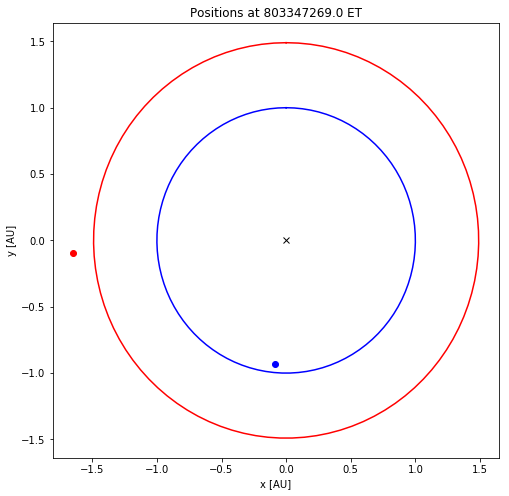

In [7]:
# plot to check (2D)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
plt.plot(dep_r[0]/au2km, dep_r[1]/au2km, 'ob')
plt.plot(arr_r[0]/au2km, arr_r[1]/au2km, 'or')
plt.plot(0,0,'xk')
# create circle to represent Earth orbit
circle_coord = mycircle(0,0,1)
plt.plot(circle_coord[:,0], circle_coord[:,1], label='1 AU orbit', c='b')
# create circle to represent Mars orbit
circle_coord = mycircle(0,0,1.49)
plt.plot(circle_coord[:,0], circle_coord[:,1], label='1.49 AU orbit', c='r')

plt.title(f'Positions at {etMean} ET')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.show()

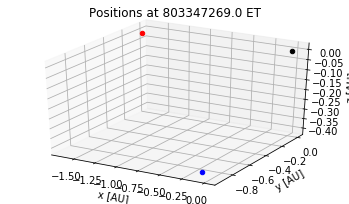

In [8]:
# plot to check (3D)
#%matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.scatter(0,0,0,c='k')
ax.scatter(dep_r[0]/au2km, dep_r[1]/au2km, dep_r[2]/au2km,c='b')
ax.scatter(arr_r[0]/au2km, arr_r[1]/au2km, arr_r[2]/au2km,c='r')
plt.title(f'Positions at {etMean} ET')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
plt.show()

In [9]:
# function to convert mean anomaly to true anomaly
def meananom2trueanom(m0,ecc):
    """function converts mean anomaly to true anomaly
    Args:
        m0 (float): mean anomaly in radians
        e (float): eccentricity
    Returns:
        (float): true anomaly in radians
    Requirements:
        from scipy import optimize
    """
    # elliptical case
    if ecc>0 and ecc<1:
        def zeroEfunc(E,m0,ecc):
            fval = E - ecc*np.sin(E) - m0
            return fval
        def zeroEprime(E,ecc):
            fpval = 1 - ecc*np.cos(E)
            return fpval
        
        # initial guess of eccentric anomaly
        E0 = m0
        # Newton-raphson method to find E with initial guess E)
        E1 = optimize.newton(zeroEfunc, args=(m0,ecc), x0=E0)#, fprime=zeroEprime)
        
        theta = 2*np.arctan(np.sqrt((1+ecc)/(1-ecc))*np.tan(E1/2))
        
    else:
        theta = NaN
        
    # convert to positive theta in case >pi
    if theta < 0:
        theta = 2*np.pi + theta
        
    return theta
    
    
# function to convert state-vector to elements
def sv2el_spice(state,epoch,mu):
    """function converts state-vector to conical elements using spice.oscelt
    Args:
        state (lst): 6-elements state vector
        epoch (float): epoch in ephemeris seconds past J2000
        mu (float): gravitational parameter
    Returns:
        (dict): dictionary of orbital elements
    """
    rp,ecc,inc,lnode,argp,m0,t0,mu_out = spice.oscelt(state,epoch,mu)
    
    # compute semi-major axis
    if ecc < 1:
        a = rp/(1-ecc)
    elif ecc > 1:
        a = rp/(ecc-1)
    else:
        a = NaN
    
    # orbital period [s]
    P = 2 * np.pi * np.sqrt(a**3/mu)
    # orbital speed [rad/s]
    n = 2*np.pi / P
    
    # true anomaly
    theta = meananom2trueanom(m0,ecc)
    
    # orbital radius
    if ecc < 1:
        r = a*(1-ecc**2)/(1+ecc*np.cos(theta))
    elif ecc > 1:
        r = a*(ecc**2-1)/(1+ecc*np.cos(theta))
        
    # perifocal frame x, y coordinates
    rxPF = r*np.cos(theta)
    ryPF = r*np.sin(theta)
    rPF = np.array([rxPF,ryPF,0])
    
    elts = {'rp':rp, 'ecc':ecc, 'inc':inc, 'lnode':lnode, 'argp':argp,
            'm0':m0,'t0':t0,'a':a, 'P':P, 'n':n, 'theta':theta, 'r':r, 'rPF':rPF}
    return elts

In [10]:
# test function converting mean anomaly to true anomaly
theta_try = meananom2trueanom(np.pi/5,0.25)
print(f'Function value for theta: {theta_try} rad; confirmed with hand calc.: 1.010 rad')

Function value for theta: 1.0101122672538323 rad; confirmed with hand calc.: 1.010 rad


In [11]:
# convert state to orbital element
dep_elts = sv2el_spice(dep_state,etMean,mu)
arr_elts = sv2el_spice(arr_state,etMean,mu)
print(dep_elts.get('a'))
print(arr_elts.get('a'))

151400330.70597562
229232072.015841


In [12]:
# HTO transfer orbit for reference
a_HTO = (dep_elts.get('a') + arr_elts.get('a'))/2
tof_HTO = np.pi * np.sqrt(a_HTO**3/mu)
print(f'Hohmann semi-major axis a = {a_HTO} km')
print(f'Time of flight via HTO: {tof_HTO/(60*60*24)} days')
phase_req = np.pi - arr_elts.get('n') * tof_HTO
print(f'Phase required: {phase_req*rad2deg} deg')
# required delta V


Hohmann semi-major axis a = 190316201.36090833 km
Time of flight via HTO: 262.05590744868005 days
Phase required: 43.83262156783695 deg


In [13]:
# initialize list for epoch to HTO
tmp_lst = []

for i in range(step):
    # compute state-vector
    sv0 = spice.spkssb(3,epochs[i],'J2000')  # (3): Earth barycenter w.r.t. SSB
    sv1 = spice.spkssb(4,epochs[i],'J2000')  # (4): Mars barycenter w.r.t. SSB
    # extract positions
    r0  = np.array([sv0[0],sv0[1],sv0[2]])
    r1  = np.array([sv1[0],sv1[1],sv1[2]])
    # angle between dep. and arr. vectors
    phi0 = np.arccos( np.dot(r0,r1)/(norm(r0)*norm(r1)) )
    # orientation between dep. and arr. vectors
    planet_orientation = np.cross(r0,r1) / norm(np.cross(r0,r1))
    # check phase angle
    phi_err = np.abs(phase_req - phi0) * rad2deg  # error in phase angle [deg]
    if phi_err < 1 and planet_orientation[2] > 0:
        print(f'Hohmann window at {spice.et2utc(epochs[i],"C",3)}')
        #print(epochs[i])
        tmp_lst.append(epochs[i])


Hohmann window at 2020 JUN 05 11:45:14.399
Hohmann window at 2020 JUN 06 11:40:33.599
Hohmann window at 2020 JUN 07 11:35:52.799
Hohmann window at 2020 JUN 08 11:31:11.999
Hohmann window at 2020 JUN 09 11:26:31.199
Hohmann window at 2022 AUG 26 20:11:02.401
Hohmann window at 2022 AUG 27 20:06:21.601
Hohmann window at 2022 AUG 28 20:01:40.801
Hohmann window at 2022 AUG 29 19:57:00.001
Hohmann window at 2022 AUG 30 19:52:19.201
Hohmann window at 2022 AUG 31 19:47:38.401
Hohmann window at 2024 OCT 24 06:24:28.801
Hohmann window at 2024 OCT 25 06:19:48.001
Hohmann window at 2024 OCT 26 06:15:07.201
Hohmann window at 2024 OCT 27 06:10:26.401
Hohmann window at 2026 DEC 03 18:06:50.400
Hohmann window at 2026 DEC 04 18:02:09.600
Hohmann window at 2026 DEC 05 17:57:28.800
Hohmann window at 2026 DEC 06 17:52:48.000
Hohmann window at 2029 JAN 06 06:17:16.799
Hohmann window at 2029 JAN 07 06:12:35.999
Hohmann window at 2029 JAN 08 06:07:55.199


In [14]:
# condense epochs to singular windows of epochs
epoch_HTO = []
dt = epochs[1] - epochs[0]
tmp_sublst = []
tmp_ct = 1

for i in range(len(tmp_lst)-1):
    if tmp_lst[i+1] - tmp_lst[i] < 1.2*dt:
        tmp_sublst.append(tmp_lst[i])
        tmp_ct += 1
        
    elif tmp_lst[i+1] - tmp_lst[i] >= 1.2*dt:
        tmp_sublst.append(tmp_lst[i])
        epoch_HTO.append(sum(tmp_sublst)/tmp_ct)
        
        del tmp_sublst[:]
        tmp_ct = 1
    
    if i == len(tmp_lst)-2:
        tmp_sublst.append(tmp_lst[i+1])
        epoch_HTO.append(sum(tmp_sublst)/tmp_ct)
        
for j in range(len(epoch_HTO)):
    print(f'Hohmann launch window at {spice.et2utc(epoch_HTO[j],"C",3)}')


Hohmann launch window at 2020 JUN 07 11:35:52.799
Hohmann launch window at 2022 AUG 29 07:59:20.401
Hohmann launch window at 2024 OCT 25 18:17:27.601
Hohmann launch window at 2026 DEC 05 05:59:49.200
Hohmann launch window at 2029 JAN 07 06:12:35.999


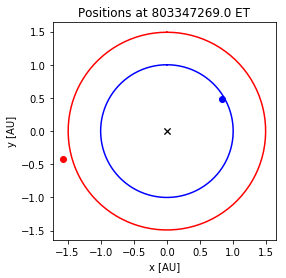

array([-16.4727192 ,  22.94470298,   9.94611371])

In [15]:
# extract positions at HTO window epoch
dep_00 = spice.spkssb(3,epoch_HTO[2],'J2000')   # (3): Earth barycenter w.r.t. SSB
arr_00 = spice.spkssb(4,epoch_HTO[2]+tof_HTO,'J2000')   # (4): Mars barycenter w.r.t. SSB

# extract position
dep_r00 = np.array([dep_00[0],dep_00[1],dep_00[2]])
arr_r00 = np.array([arr_00[0],arr_00[1],arr_00[2]])
# extract velocities
dep_v00 = np.array([dep_00[3],dep_00[4],dep_00[5]])
arr_v00 = np.array([arr_00[3],arr_00[4],arr_00[5]])

# plot to check (2D)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
plt.plot(dep_r00[0]/au2km, dep_r00[1]/au2km, 'ob')
plt.plot(arr_r00[0]/au2km, arr_r00[1]/au2km, 'or')
plt.plot(0,0,'xk')
plt.plot(0,0,'xk')
# create circle to represent Earth orbit
circle_coord = mycircle(0,0,1)
plt.plot(circle_coord[:,0], circle_coord[:,1], label='1 AU orbit', c='b')
# create circle to represent Mars orbit
circle_coord = mycircle(0,0,1.49)
plt.plot(circle_coord[:,0], circle_coord[:,1], label='1.49 AU orbit', c='r')
plt.title(f'Positions at {etMean} ET')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.show()

dep_v00

In [16]:
# Lambert problem with TOF of HTO --- planar change should be done through deep space manoeuver!!
# >>> convert position and velocity vector to planar first...?

dep_vHTO,arr_vHTO = lb.lambert(mu=mu, r1=dep_r00, r2=arr_r00, tof=tof_HTO, grade='pro')


In [17]:
dep_state_try = [*dep_r00, *dep_vHTO]
arr_state_try = [*arr_r00, *arr_vHTO]

dep_state = sv2el_spice(dep_state_try,epoch_HTO[0],mu)
arr_state = sv2el_spice(arr_state_try,epoch_HTO[0]+tof_HTO,mu)

print(dep_state)
print(arr_state)
# a should be close to: 190316201.36090833 km

{'rp': 145820858.6669621, 'ecc': 0.25277755874040875, 'inc': 0.46352308330089753, 'lnode': 0.07538339146591873, 'argp': 0.15323467946248548, 'm0': 0.20058824477324472, 't0': 644801821.9838741, 'a': 195150534.31900704, 'P': 47019571.65175422, 'n': 1.3362914817079519e-07, 'theta': 0.3448194033042377, 'r': 147573605.58910823, 'rPF': array([1.38886909e+08, 4.98838214e+07, 0.00000000e+00])}
{'rp': 145820858.66696176, 'ecc': 0.2527775587404112, 'inc': 0.46352308330089753, 'lnode': 0.07538339146591878, 'argp': 0.15323467946248695, 'm0': 3.226170028799734, 't0': 667443452.3874401, 'a': 195150534.31900725, 'P': 47019571.6517543, 'n': 1.3362914817079497e-07, 'theta': 3.193748304653884, 'r': 244367799.47008482, 'rPF': array([-2.44035509e+08, -1.27393842e+07,  0.00000000e+00])}


In [18]:
# rotational matrices
def rotMat(axis,theta):
    """Function computes rotational matrix going from one to another
    Args:
        axis (int): 1, 2, or 3 (axis about which to rotate)
    Returns:
    """
    if axis == 1:
        rotmat = np.array([[1, 0, 0],
                           [0, np.cos(theta), np.sin(theta)],
                           [0, -np.sin(theta), np.cos(theta)]])
    elif axis == 2:
        rotmat = np.array([[np.cos(theta), 0, -np.sin(theta)],
                           [0, 1, 0],
                           [np.sin(theta), 0, np.cos(theta)]])
    elif axis == 3:
        rotmat = np.array([[np.cos(theta), np.sin(theta), 0],
                           [-np.sin(theta), np.cos(theta), 0],
                           [0, 0, 1]])
    else:
        rotmat = NaN
        
    return rotmat


In [19]:
# try rotational matrix function
rom   = rotMat(3,-dep_state.get('argp'))
rinc  = rotMat(1,-dep_state.get('inc'))
rraan = rotMat(3,-dep_state.get('lnode'))

# construct rotation for particular transfer orbit
print(f'using matmul:\n{np.matmul(rinc,rom)}\n')
print(f'using dot:\n{np.dot(rinc,rom)}')
tmp1 = np.dot(rraan,rinc)
tmp2 = np.dot(tmp1,rom)

using matmul:
[[ 0.98828252 -0.1526357   0.        ]
 [ 0.13653002  0.88400179 -0.44710221]
 [ 0.06824376  0.4418633   0.89448287]]

using dot:
[[ 0.98828252 -0.1526357   0.        ]
 [ 0.13653002  0.88400179 -0.44710221]
 [ 0.06824376  0.4418633   0.89448287]]


In [20]:
# create array of theta
theta_ar = np.linspace(dep_state.get('theta'),arr_state.get('theta'),1000)
rGECx = np.zeros([len(theta_ar)])
rGECy = np.zeros([len(theta_ar)])
rGECz = np.zeros([len(theta_ar)])
for i in range(len(theta_ar)):
    rnorm = dep_state.get('a')*(1-(dep_state.get('ecc'))**2)/(1+dep_state.get('ecc')*np.cos(theta_ar[i]))
    rPF = np.array([rnorm*np.cos(theta_ar[i]), rnorm*np.sin(theta_ar[i]), 0])
    rGEC = np.dot(tmp2,rPF)
    rGECx[i] = rGEC[0]
    rGECy[i] = rGEC[1]
    rGECz[i] = rGEC[2]

dep_r00


array([1.24528114e+08, 7.26443921e+07, 3.15199950e+07])

In [21]:
print(f'x {rGECx[0]:.5}, y {rGECy[0]:.5}, z {rGECz[0]:.5}')

x 1.2453e+08, y 7.2644e+07, z 3.152e+07


In [22]:
# consider pseudo-Hohmann transfer that patches the two orbits with half-ellipse
r0 = np.sqrt(dep_r00[0]**2 + dep_r00[1]**2 + dep_r00[2]**2)
r1 = np.sqrt(arr_r00[0]**2 + arr_r00[1]**2 + arr_r00[2]**2)
print(f'periapsis: {r0:.5}, apoapsis: {r1:.5}')
aHTO_2D = (r0+r1)/2
eHTO_2D = (r1-r0)/(r1+r0)
bHTO_2D = aHTO_2D * np.sqrt(1-eHTO_2D**2)

# initialize x-coordinates for ellpise construction
xHTO_2Dtmp = np.linspace(-aHTO_2D,aHTO_2D,1000)
xHTO_2D = []
yHTO_2D = []
xHTO_3D = []
yHTO_3D = []
zHTO_3D = []

for i in range(len(xHTO_2Dtmp)):
    # compute y-coordinate
    ycoord_regular = np.sqrt(1 - xHTO_2Dtmp[i]**2/aHTO_2D**2)*bHTO_2D
    # shift origin of x-coordinate to match focus to [0,0]
    xcoord_regular = xHTO_2Dtmp[i] - np.sqrt(aHTO_2D**2 - bHTO_2D**2)
    # rotate x,y coordinates by initial theta of dep_r00
    rotheta = dep_state.get('theta')
    xcoord_rot = xcoord_regular * np.cos(rotheta) - ycoord_regular*np.sin(rotheta)
    ycoord_rot = xcoord_regular * np.sin(rotheta) + ycoord_regular*np.cos(rotheta)
    
    # store, normalizing by au2km
    yHTO_2D.append( ycoord_rot/au2km )
    # shift origin of x-coordinate to match focus to [0,0]
    xHTO_2D.append( xcoord_rot/au2km )
    
    # convert from 2D to 3D through rotational matrices
    coord_3DPF = np.array([xcoord_rot/au2km, ycoord_rot/au2km, 0])   # perifocal frame
    coord_3D = np.dot(tmp2,coord_3DPF)
    xHTO_3D.append( coord_3D[0] )
    yHTO_3D.append( coord_3D[1] )
    zHTO_3D.append( coord_3D[2] )
    
    

periapsis: 1.4757e+08, apoapsis: 2.4437e+08


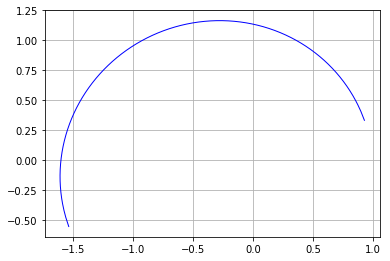

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, aspect='equal')
#ax.scatter(0,0,c='k')
ax.plot(xHTO_2D,yHTO_2D, c='b',linewidth='1')
ax.grid()
#ax.scatter(arr_r[0]/au2km, arr_r[1]/au2km, arr_r[2]/au2km,c='r')
plt.show()

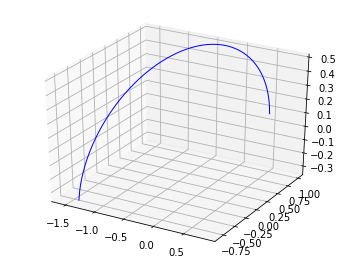

In [24]:
#%matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, aspect='equal',projection='3d')
#ax.scatter(0,0,c='k')
ax.plot(xHTO_3D,yHTO_3D,zHTO_3D, c='b',linewidth='1')
ax.grid()
#ax.scatter(arr_r[0]/au2km, arr_r[1]/au2km, arr_r[2]/au2km,c='r')
plt.show()

In [25]:
# extract position of earth and mars from spice
Earth_xpos = []
Earth_ypos = []
Earth_zpos = []
Mars_xpos = []
Mars_ypos = []
Mars_zpos = []

for i in range(len(epochs)):
    stateE = spice.spkssb(3,epochs[i],'J2000')
    stateM = spice.spkssb(4,epochs[i],'J2000')
    Earth_xpos.append(stateE[0]/au2km)
    Earth_ypos.append(stateE[1]/au2km)
    Earth_zpos.append(stateE[2]/au2km)
    Mars_xpos.append(stateM[0]/au2km)
    Mars_ypos.append(stateM[1]/au2km)
    Mars_zpos.append(stateM[2]/au2km)


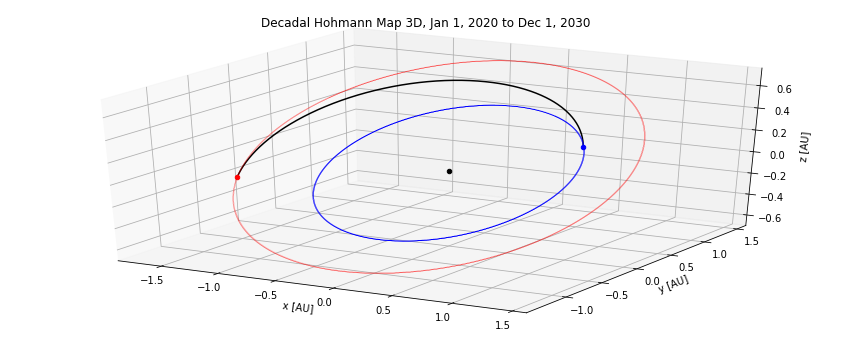

In [29]:
#%matplotlib
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111, aspect='auto', projection='3d')

ax.scatter(0,0,0,c='k')
ax.scatter(dep_r00[0]/au2km, dep_r00[1]/au2km, dep_r00[2]/au2km, marker='o',c='b')
ax.scatter(arr_r00[0]/au2km, arr_r00[1]/au2km, arr_r00[2]/au2km, marker='o',c='r')

ax.plot(rGECx/au2km,rGECy/au2km,rGECz/au2km,c='k')

ax.plot(Earth_xpos, Earth_ypos, Earth_zpos,c='b',linewidth='0.1')
ax.plot(Mars_xpos,  Mars_ypos,  Mars_zpos,c='r',linewidth='0.1')
#ax.plot(xHTO_3D,yHTO_3D,zHTO_3D, c='k',linewidth='1')
#ax.scatter(arr_r[0]/au2km, arr_r[1]/au2km, arr_r[2]/au2km,c='r')
plt.title(f'Decadal Hohmann Map 3D, {tstart} to {tend}')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')

plt.show()

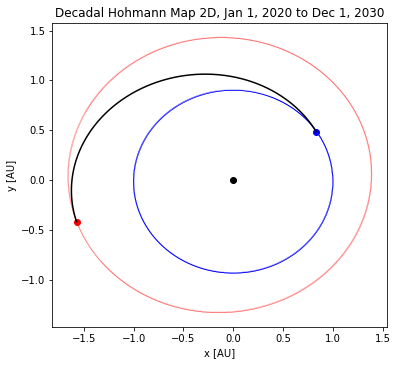

In [31]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, aspect='equal')
# planets
ax.scatter(0,0,c='k')
ax.scatter(dep_r00[0]/au2km, dep_r00[1]/au2km, marker='o',c='b')
ax.scatter(arr_r00[0]/au2km, arr_r00[1]/au2km, marker='o',c='r')
# orbits
ax.plot(Earth_xpos, Earth_ypos, c='b',linewidth='0.1')
ax.plot(Mars_xpos,  Mars_ypos, c='r',linewidth='0.1')
# transfers
ax.plot(rGECx/au2km,rGECy/au2km,c='k')
#ax.plot(xHTO_2D,yHTO_2D, c='k',linewidth='1')
#ax.scatter(arr_r[0]/au2km, arr_r[1]/au2km, arr_r[2]/au2km,c='r')
plt.title(f'Decadal Hohmann Map 2D, {tstart} to {tend}')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
plt.show()